In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from flash_ansr import FlashANSR, get_path, FlashANSRTransformer, ExpressionSpace, GenerationConfig
from flash_ansr.expressions.utils import codify, num_to_constants

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [2]:
MODEL = 'v9.1'
CHECKPOINT = ''

In [3]:
nsr = FlashANSR.load(
    directory=get_path('models', 'ansr-models', MODEL, CHECKPOINT),
    # generation_config=GenerationConfig('beam_search', beam_width=32),
    generation_config=GenerationConfig('softmax_sampling', choices=128),
    n_restarts=8,
).to(device)

print(f'{nsr.flash_ansr_transformer.n_params:,} parameters')

27,146,787 parameters


In [4]:
demo_expressions = [
    ('x**2', None, (-5, 5)),
    ('sin(x)', None, (-5, 5)),
    ('-x + log(x + x**4)', None, (1, 5)),
    ('x1**2 + 2*x1 + 1', (2, 1), (1, 5)),
    ('exp(- x**2)', None, (-5, 5)),
    ('x**3 + 2*x**2 + 1', (2, 1), (-5, 5)),
    ('exp(- (x - 3.4)**2)', (3.4,), (-5, 5)),
    ('exp(- (x - 1.4)**2 / 4.3)', (1.4, 4.3), (-5, 5)),
    ('cos(3.3 * x) * exp(-x * 0.5)', (3.3, 0.5,), (0, 5)),
    ('1.2', (1.2,), (-5, 5)),
    ('sin(tan(x))', None, (-5, 5)),
    ('asin((sin(x1) / x1))', None, (-10, 10)),
]

expression, constants, xlim = demo_expressions[2]

prefix_expression = nsr.expression_space.parse_expression(expression, mask_numbers=True)
prefix_expression_w_num = nsr.expression_space.operators_to_realizations(prefix_expression)
prefix_expression_w_constants, constants_names = num_to_constants(prefix_expression_w_num)
code_string = nsr.expression_space.prefix_to_infix(prefix_expression_w_constants, realization=True)
code = codify(code_string, nsr.expression_space.variables + constants_names)

if constants is None:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0)
else:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0, *constants)

In [5]:
x = np.random.uniform(*xlim, 128)

y = demo_function(x)

if isinstance(y, float):
    y = np.full_like(x, y)

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(-1).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1).to(device)

print(x_tensor.shape, y_tensor.shape)

torch.Size([128, 1]) torch.Size([128, 1])


Text(0.5, 1.0, 'Data')

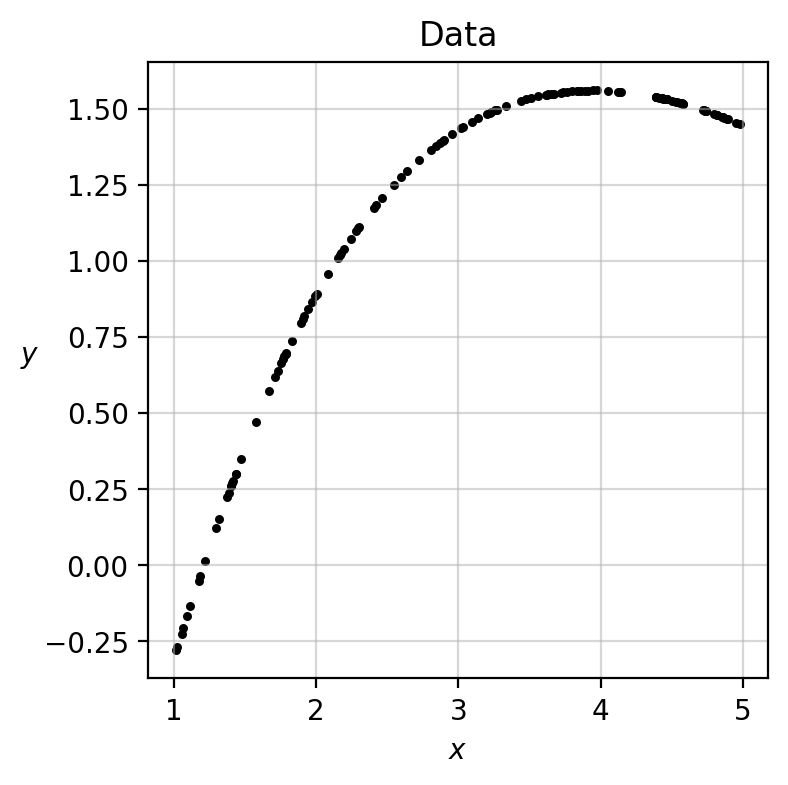

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)

ax.scatter(x, y, label=f'f(x) = {expression}', color='k', s=5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$', rotation=0, labelpad=5)
# ax.legend()
ax.grid(alpha=0.5)
ax.set_title('Data')
# ax.set_ylim(-0.1, 1.5)

In [7]:
x_linspace = np.linspace(xlim[0] - 0.5, xlim[1] + 0.5, 1000)
x_linspace_tensor = torch.tensor(x_linspace, dtype=torch.float32).unsqueeze(-1).to(device)

In [8]:
y_pred_list = []
y_pred_linspace_list = []
fvus = []
expression_transformed_list = []

for complexity in tqdm(range(20)):
    nsr.fit(x_tensor, y_tensor, complexity=complexity, converge_error='print')

    y_pred = nsr.predict(x_tensor.cpu())
    y_pred_list.append(y_pred)

    y_pred_linspace = nsr.predict(x_linspace_tensor.cpu())
    y_pred_linspace_list.append(y_pred_linspace)

    fvu = np.nanmean((y_pred[:, 0].numpy() - demo_function(x.astype(np.float32)))**2) / np.nanvar(demo_function(x.astype(np.float32)))
    fvus.append(fvu)

    expression_pred_transformed = nsr._results[0]['refiner'].transform(nsr._results[0]['expression'], 0, return_prefix=True)
    expression_pred_transformed_infix = nsr.expression_space.prefix_to_infix(expression_pred_transformed, power='**')
    expression_transformed_list.append(expression_pred_transformed_infix)

100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


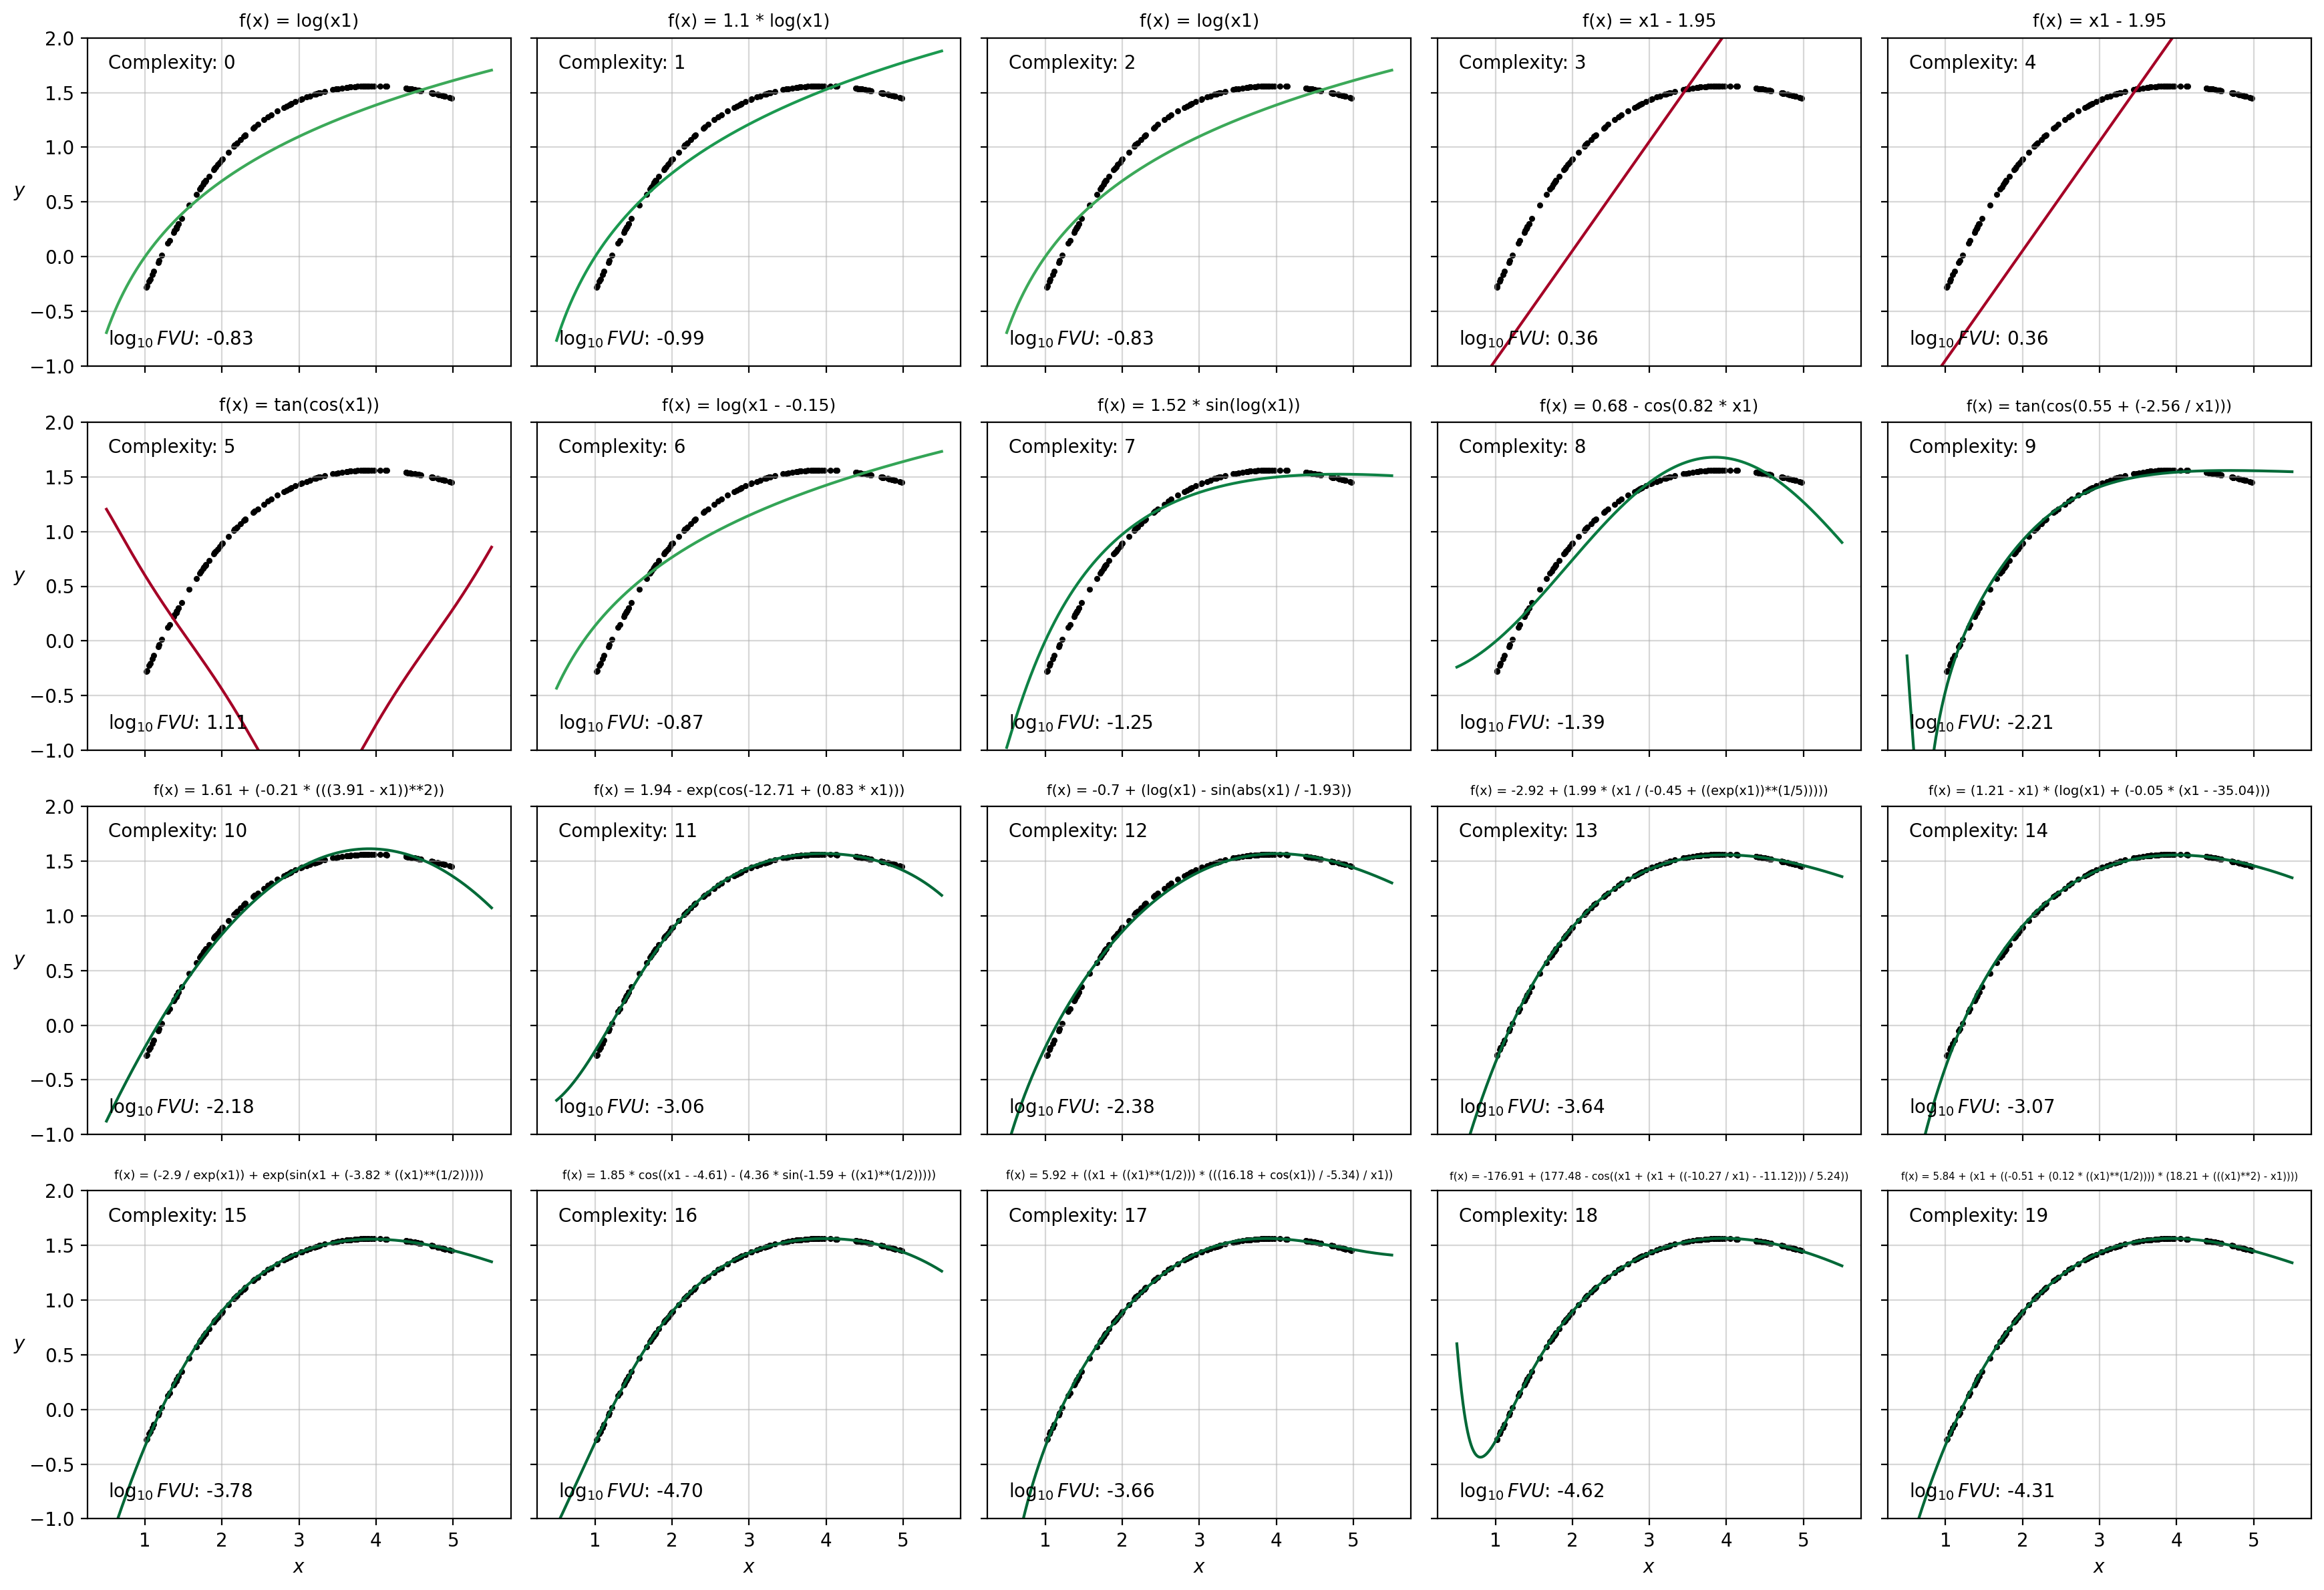

In [9]:
COLS = 5
ROWS = np.ceil(len(y_pred_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3.5, ROWS * 3), dpi=200, sharex=True, sharey=True)

for i, (y_pred, y_pred_linspace, fvu, expression_transformed, ax) in enumerate(zip(y_pred_list, y_pred_linspace_list, fvus, expression_transformed_list, axes.flatten())):
    ax.scatter(x, y, color='k', s=5)
    ax.plot(x_linspace, y_pred_linspace, color=plt.get_cmap('RdYlGn')(1 - fvu))
    ax.set_title(f'f(x) = {expression_transformed}', fontsize=10 - 0.06 * (len(expression_transformed)))
    ax.annotate(f'Complexity: {i}', (0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=10)
    ax.annotate(f'$\\log_{{10}} FVU$: {np.log10(fvus[i]):.2f}', (0.05, 0.05), xycoords='axes fraction', ha='left', va='bottom', fontsize=10)
    ax.grid(alpha=0.5)
    ax.set_ylim(-1, 2)

for i in range(ROWS):
    axes[i, 0].set_ylabel('$y$', rotation=0, labelpad=5)

for j in range(COLS):
    axes[-1, j].set_xlabel('$x$')

fig.tight_layout()

In [10]:
# y_pred = [[nsr.predict(x_tensor.cpu(), nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result['fits']))] for beam_id, result in enumerate(nsr._results)]
# y_pred_linspace = [[nsr.predict(x_linspace_tensor.cpu(), nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result['fits']))] for beam_id, result in enumerate(nsr._results)]

In [11]:
# group_size = 4

# COLS = len(y_pred) // group_size // 2
# ROWS = np.ceil(len(y_pred) / group_size / COLS).astype(int)

# fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 4.5, ROWS * 4), dpi=150, sharex=True, sharey=True)

# for i, ax in enumerate(axes.flatten()):
#     for within_ax_i, j in enumerate(range(group_size * i, group_size * (i + 1))):
#         if j >= len(y_pred):
#             ax.axis('off')
#             continue
#         fvu = np.nanmean((y_pred[j][0][:, 0].numpy() - demo_function(x.astype(np.float32)))**2) / np.nanvar(demo_function(x.astype(np.float32)))
#         expression_pred_transformed = nsr._results[j]['refiner'].transform(nsr._results[j]['expression'], 0, return_prefix=True)
#         expression_pred_transformed_infix = nsr.expression_space.prefix_to_infix(expression_pred_transformed, power='**')

#         label = f'{expression_pred_transformed_infix}\nFVU = {fvu:.3f}, \nlog p = {nsr._results[j]["log_prob"]:.2f}'

#         ax.plot(x_linspace, y_pred_linspace[j][0], color=plt.get_cmap('plasma')((within_ax_i / group_size)), label=label, alpha=0.8)
        
#         if i >= (ROWS - 1) * COLS:
#             ax.set_xlabel('$x$')
#         if i % COLS == 0:
#             ax.set_ylabel('$y$', rotation=0, labelpad=5)

#     ax.legend(loc='lower left', mode='expand', bbox_to_anchor=(0, 1.02, 1, 0.2), ncol=2, fontsize=7, labelspacing=1)
#     ax.scatter(x, y, color='k', s=5, zorder=4)
#     ax.set_ylim(-0.5, 1.6)
#     ax.grid(alpha=0.5)

# fig.tight_layout(h_pad=1)

In [12]:
expression_pred = nsr._results[0]['expression']
expression_pred_transformed = nsr.refiner.transform(expression_pred, 0, return_prefix=True)
expression_pred_transformed_infix = nsr.expression_space.prefix_to_infix(expression_pred_transformed, power='**')

AttributeError: 'FlashANSR' object has no attribute 'refiner'

In [ ]:
mse = nsr._results[0]['fits'][0][-1]
fvu = np.mean((y_pred[:, 0] - demo_function(x.astype(np.float32)))**2) / np.var(demo_function(x.astype(np.float32)))

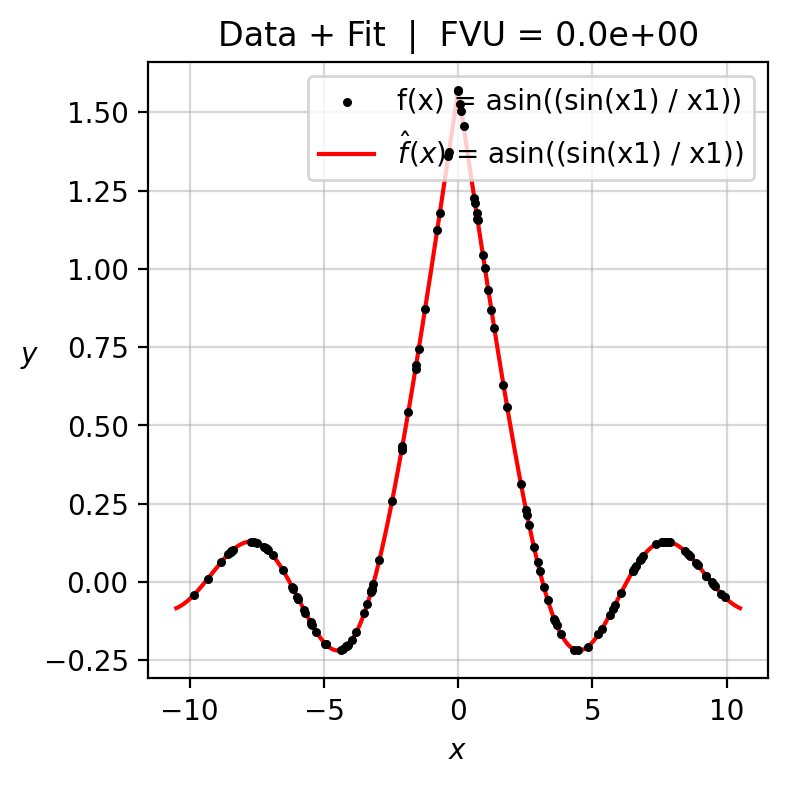

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)

ax.scatter(x, y, label=f'f(x) = {expression}', color='k', s=5, zorder=10)
ax.plot(x_linspace, y_pred_linspace, label=r'$\hat f(x)$ = ' + expression_pred_transformed_infix, color='r')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$', rotation=0, labelpad=5)
ax.legend()
# ax.set_title(f'Data + Fit  |  MSE = {mse:.1e}')
ax.set_title(f'Data + Fit  |  FVU = {fvu:.1e}')
# ax.set_title(f'Data + Fit')
ax.grid(alpha=0.5)
# ax.set_ylim(-0.1, 1.5)